# EnvisionBOX Summer School 2025, Day 4: Bringing all together
## Merging multimodal timeseries

Let's first prepare the environment

In [45]:
# packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

curfolder = os.getcwd()

# folders with processed data
MTfolder_processed = os.path.join(curfolder, 'processedMotion')
ACfolder_processed = os.path.join(curfolder, 'processedAudio')

# folder to save merged data
TSmerged = os.path.join(curfolder, 'merged')

# create the folder
if not os.path.exists(TSmerged):
    os.makedirs(TSmerged)

# prepare all files
mtfiles = glob.glob(os.path.join(MTfolder_processed, '*.csv'))
envfiles = glob.glob(os.path.join(ACfolder_processed, '*.csv'))


The main challenge of merging the data is the fact that usually, different signals sample at different rates.

Let's look at the two signals we have

In [46]:
# load from each files one and calculate the sr
mt = pd.read_csv(mtfiles[0])
env = pd.read_csv(envfiles[0])

# calculate the sr
sr_mt = 1/(mt['Time'][1] - mt['Time'][0])
sr_env = 1/(env['time'][1] - env['time'][0])


# print them all
print('kinematics:', sr_mt*1000)
print('envelope:', sr_env*1000)

kinematics: 30.0
envelope: 44100.000000000095


There are essentially three choices on the table

- we can downsample the audio signal to the movement signal
- we can upsample the movement signal to the audio signal
- we can set new sampling rate and upsample/downsample both signals to that rate

What do you think is the best choice?

# Merging signals on a common sampling rate

In [47]:
import warnings
warnings.filterwarnings("ignore")

desired_sr = 0.5    # this is the sr we are going to merge on (in Hz/sec)

error_log = []

for file in mtfiles:

    mt_df = pd.read_csv(file)

    # get trial id
    fileid = mt_df['file'][0]

    print('working on ' + fileid)

    # 
    search = fileid.split('_')[0] + '_' + fileid.split('_')[1]
    
    # find the same trialid in envfiles
    env_file = [x for x in envfiles if search in x]
    try:
        env_df = pd.read_csv(env_file[0])

    except IndexError:
        print('IndexError: ' + search + ' not found')
        errormessage = 'IndexError: ' + search + ' not found for ENV'
        error_log.append(errormessage)
        continue

    # rename time to Time
    env_df.rename(columns={'time': 'Time'}, inplace=True)

    ############## MERGING ########################

    #### regularize sr in motion tracking
    time_new = np.arange(0, max(mt_df['Time']), 1/desired_sr)
    mt_interp = pd.DataFrame({'Time': time_new})
    

    # merge mt with df with new time
    merge0 = pd.merge(mt_interp, mt_df, on='Time', how='outer')

    # interpolate all columns in file 
    colstoint = merge0.columns
    colstoint = [x for x in colstoint if 'Time' not in x]
    colstoint = [x for x in colstoint if 'file' not in x]

    for col in colstoint:
        merge0[col] = merge0[col].interpolate(method='linear', x = merge0['Time'])
    
    ########################
    # add trialid and time
    merge0['file'] = fileid
    
    ########### merge the mt with env

    merge1 = pd.merge(merge0, env_df, on=['Time', 'file'], how='outer')

    # interpolate missing values of envelope and audio
    colstoint = merge1.columns
    colstoint = [x for x in colstoint if 'audio' in x or 'envelope' in x]

    for col in colstoint: 
        merge1[col] = merge1[col].interpolate(method='linear', x = merge1['Time'])

    # now we can kick out all values where kinematics is NaN
    merge1 = merge1[~np.isnan(merge1['RHip_x'])]

    ######### HERE WOULD COME OUR OTHER SIGNALS, IF WE HAVE THEM #######

    # this is final df
    merge_final = merge1     
   
    # write to csv
    merge_final.to_csv(TSmerged + '/merged_' + fileid + '.csv', index=False)  


working on femalemonologue2_t3_0-619


Let's inspect a file

In [48]:
merged_files = glob.glob(TSmerged + '/merged*.csv')
sample = pd.read_csv(merged_files[0]) 

# Display
sample.head(20)

,Time,RHip_x,RHip_z,RHip_y,RKnee_x,RKnee_z,RKnee_y,RAnkle_x,RAnkle_z,RAnkle_y,...,RAnkle_speed,RAnkle_acc,RAnkle_jerk,LWrist_speed,LWrist_acc,LWrist_jerk,file,audio,envelope,envelope_change
0,0.000000,-293.337460,10.234449,30.941256,-301.328509,-28.660296,30.891148,-305.459137,-65.825919,32.352310,...,0.005712,-0.000210,0.000410,0.083037,-0.026417,-0.003469,femalemonologue2_t3_0-619,0.002197,0.000010,-2.491372e-06
1,2.000000,-293.337847,10.254155,30.947090,-301.301941,-28.643730,30.901894,-305.493881,-65.825807,32.352799,...,0.005753,-0.000166,0.000410,0.079894,-0.026329,-0.003185,femalemonologue2_t3_0-619,0.003586,0.001751,-1.198361e-06
2,4.000000,-293.338233,10.273861,30.952924,-301.275374,-28.627164,30.912639,-305.528626,-65.825694,32.353289,...,0.005794,-0.000121,0.000409,0.076751,-0.026241,-0.002901,femalemonologue2_t3_0-619,0.005157,0.003469,3.118475e-08
3,6.000000,-293.338619,10.293566,30.958758,-301.248806,-28.610598,30.923385,-305.563371,-65.825582,32.353778,...,0.005835,-0.000077,0.000409,0.073608,-0.026153,-0.002617,femalemonologue2_t3_0-619,0.001907,0.005143,1.177526e-06
4,8.000000,-293.339005,10.313272,30.964592,-301.222238,-28.594032,30.934131,-305.598116,-65.825469,32.354268,...,0.005875,-0.000033,0.000408,0.070466,-0.026065,-0.002333,femalemonologue2_t3_0-619,0.004593,0.006756,2.225682e-06
5,10.000000,-293.339391,10.332978,30.970426,-301.195670,-28.577466,30.944877,-305.632861,-65.825357,32.354757,...,0.005916,0.000011,0.000407,0.067323,-0.025977,-0.002049,femalemonologue2_t3_0-619,0.005493,0.008311,3.175022e-06
6,12.000000,-293.339777,10.352684,30.976260,-301.169102,-28.560900,30.955622,-305.667605,-65.825244,32.355246,...,0.005957,0.000056,0.000407,0.064180,-0.025889,-0.001765,femalemonologue2_t3_0-619,0.000275,0.009763,3.997397e-06
7,14.000000,-293.340163,10.372389,30.982094,-301.142534,-28.544334,30.966368,-305.702350,-65.825132,32.355736,...,0.005998,0.000100,0.000406,0.061037,-0.025801,-0.001481,femalemonologue2_t3_0-619,-0.003448,0.011123,4.700798e-06
8,16.000000,-293.340549,10.392095,30.987928,-301.115966,-28.527768,30.977114,-305.737095,-65.825019,32.356225,...,0.006038,0.000144,0.000405,0.057894,-0.025713,-0.001197,femalemonologue2_t3_0-619,-0.004196,0.012386,5.284882e-06
9,18.000000,-293.340935,10.411801,30.993762,-301.089398,-28.511202,30.987859,-305.771840,-65.824907,32.356715,...,0.006079,0.000188,0.000405,0.054751,-0.025625,-0.000913,femalemonologue2_t3_0-619,-0.002594,0.013551,5.751830e-06


And we can also nicely plot two signals together

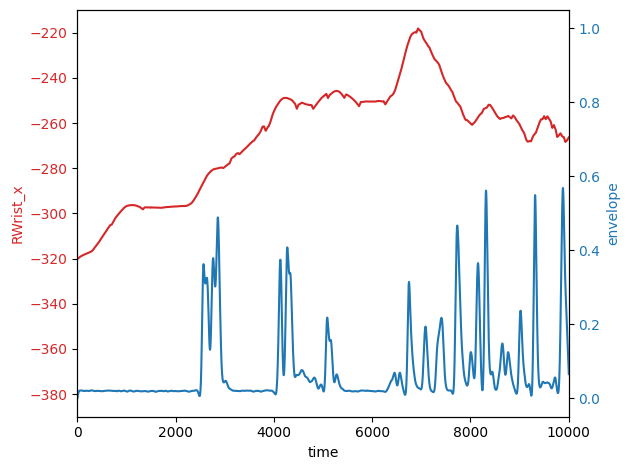

In [49]:

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('RWrist_x', color=color)
ax1.plot(sample['Time'], sample['RWrist_x'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('envelope', color=color)  # we already handled the x-label with ax1
ax2.plot(sample['Time'], sample['envelope'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xlim([0, 10000])  # limit x-axis to first 10 seconds

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# Adding annotations

In [50]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd

curfolder = os.getcwd()

# Here we store the merged timeseries data
mergedfolder = os.path.join(curfolder, 'merged')
mergedfiles = glob.glob(os.path.join(mergedfolder, '*.csv'))

# Here we store the predicted motion annotations
annofolder = datafolder = os.path.join(curfolder, '..', 'Day3_UsingEnvisionHGdetector', 'output')
annofiles = glob.glob(os.path.join(annofolder, '*.eaf'))

# Create folder for the txt annotations
txtannofolder = os.path.join(curfolder, 'annotations_txt')
if not os.path.exists(txtannofolder):
    os.makedirs(txtannofolder)

In [51]:
import xml.etree.ElementTree as ET

# Function to parse elan file
def parse_eaf_file(eaf_file, rel_tiers):
    tree = ET.parse(eaf_file)
    root = tree.getroot()

    annotations = []
    relevant_tiers = {rel_tiers}
    
    time_order = root.find('TIME_ORDER')
    if time_order == None: 
        print ("no time order")
        print()
        annotations.append({
                        'tier_id': 'na',
                        'annotation_id': 'na',
                        'start_time': 'na',
                        'end_time': 'na',
                        'annotation_value': None
                    })
    else:
        time_slots = {time_slot.attrib['TIME_SLOT_ID']: time_slot.attrib['TIME_VALUE'] for time_slot in time_order}


        for tier in root.findall('TIER'):
            tier_id = tier.attrib['TIER_ID']
            if tier_id in relevant_tiers:
                for annotation in tier.findall('ANNOTATION/ALIGNABLE_ANNOTATION'):
                    # Ensure required attributes are present
                    if 'TIME_SLOT_REF1' in annotation.attrib and 'TIME_SLOT_REF2' in annotation.attrib:
                        ts_ref1 = annotation.attrib['TIME_SLOT_REF1']
                        ts_ref2 = annotation.attrib['TIME_SLOT_REF2']
                        # Get annotation ID if it exists, otherwise set to None
                        ann_id = annotation.attrib.get('ANNOTATION_ID', None)
                        annotation_value = annotation.find('ANNOTATION_VALUE').text.strip()
                        annotations.append({
                            'tier_id': tier_id,
                            'annotation_id': ann_id,
                            'start_time': time_slots[ts_ref1],
                            'end_time': time_slots[ts_ref2],
                            'annotation_value': annotation_value
                        })

    return annotations

# Function to load annotations into csv
def fillAnno(TSfile, ANNOfile, colname):
    TSfile[colname] = None
    for row in ANNOfile.iterrows():
        start = float(row[1][0])
        end = float(row[1][1])
        value = str(row[1][2])
        TSfile.loc[(TSfile['Time'] >= start) & (TSfile['Time'] <= end), colname] = value

In [52]:
ges_anno = txtannofolder + '/gesture_annotations.txt'

with open(ges_anno, 'w') as f:
    for file in annofiles:
        # get the filename as the last element
        filename = os.path.basename(file).split('.')[0]
        print('working on ' + filename)
        # parse the file
        annotations = parse_eaf_file(file, 'PREDICTED')
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

working on 03_example
working on femalemonologue1_t1-cam22
working on femalemonologue1_t2-cam22
working on femalemonologue1_t3-cam22
working on femalemonologue2_t3-cam22
working on femalemonologue2_t4-cam22
working on malemonologue1_t3-cam22
working on malemonologue1_t4-cam22
working on malemonologue2_t2-cam22
working on test_female
working on test_male


Now we can merge our merged signals with the annotations

In [53]:

# These are the annotations per tier that we just created from manual annotations
ges_anno = os.path.join(txtannofolder, 'gesture_annotations.txt')

finalfolder = os.path.join(curfolder, 'TS_annotated/')
if not os.path.exists(finalfolder):
    os.makedirs(finalfolder)

for file in mergedfiles:
    print('working on ' + file)

    # Load the merged file
    merged = pd.read_csv(file)

    # Get the trialid
    fileid = merged['file'][0]

    search = fileid.split('_')[0] + '_' + fileid.split('_')[1]
    
    # Load the annotations as df
    anno_df = pd.read_csv(ges_anno, sep='\t', header=None)

    # Find the annotations that match (even partially) the search
    anno_trial = anno_df[anno_df[3].str.contains(search, na=False)]
    
    if anno_trial.empty:
        print("empty")
        print('no annotations for ' + search)
        #add a column
        continue
    
    else:
        fillAnno(merged, anno_trial, 'Gesture')
        
    df = merged.copy()

    # check if each column exists in the dataframe
    colnames = ['Gesture']
    for colname in colnames:
        # create a column if it doesn't exist. If it does, switch the labels. 
        if colname not in df:
            df[colname] = 'no movement'
        else:
            df[colname] = df[colname].fillna('no movement')

    # save the dataframe to TS_annotated
    df.to_csv(finalfolder + 'annotated_' + fileid + '.csv', index=False)



working on c:\Users\Sarka Kadava\Documents\Github\envisionBOX_SummerschoolAmsterdam2025\Day4_MultimodalMerging\merged\merged_femalemonologue2_t3_0-619.csv


Now we can again inspect a file

In [54]:
annofiles = glob.glob(finalfolder + '\*.csv')
sample = pd.read_csv(annofiles[0]) 

# Display
sample.head(20)

,Time,RHip_x,RHip_z,RHip_y,RKnee_x,RKnee_z,RKnee_y,RAnkle_x,RAnkle_z,RAnkle_y,...,RAnkle_acc,RAnkle_jerk,LWrist_speed,LWrist_acc,LWrist_jerk,file,audio,envelope,envelope_change,Gesture
0,0.000000,-293.337460,10.234449,30.941256,-301.328509,-28.660296,30.891148,-305.459137,-65.825919,32.352310,...,-0.000210,0.000410,0.083037,-0.026417,-0.003469,femalemonologue2_t3_0-619,0.002197,0.000010,-2.491372e-06,no movement
1,2.000000,-293.337847,10.254155,30.947090,-301.301941,-28.643730,30.901894,-305.493881,-65.825807,32.352799,...,-0.000166,0.000410,0.079894,-0.026329,-0.003185,femalemonologue2_t3_0-619,0.003586,0.001751,-1.198361e-06,no movement
2,4.000000,-293.338233,10.273861,30.952924,-301.275374,-28.627164,30.912639,-305.528626,-65.825694,32.353289,...,-0.000121,0.000409,0.076751,-0.026241,-0.002901,femalemonologue2_t3_0-619,0.005157,0.003469,3.118475e-08,no movement
3,6.000000,-293.338619,10.293566,30.958758,-301.248806,-28.610598,30.923385,-305.563371,-65.825582,32.353778,...,-0.000077,0.000409,0.073608,-0.026153,-0.002617,femalemonologue2_t3_0-619,0.001907,0.005143,1.177526e-06,no movement
4,8.000000,-293.339005,10.313272,30.964592,-301.222238,-28.594032,30.934131,-305.598116,-65.825469,32.354268,...,-0.000033,0.000408,0.070466,-0.026065,-0.002333,femalemonologue2_t3_0-619,0.004593,0.006756,2.225682e-06,no movement
5,10.000000,-293.339391,10.332978,30.970426,-301.195670,-28.577466,30.944877,-305.632861,-65.825357,32.354757,...,0.000011,0.000407,0.067323,-0.025977,-0.002049,femalemonologue2_t3_0-619,0.005493,0.008311,3.175022e-06,no movement
6,12.000000,-293.339777,10.352684,30.976260,-301.169102,-28.560900,30.955622,-305.667605,-65.825244,32.355246,...,0.000056,0.000407,0.064180,-0.025889,-0.001765,femalemonologue2_t3_0-619,0.000275,0.009763,3.997397e-06,no movement
7,14.000000,-293.340163,10.372389,30.982094,-301.142534,-28.544334,30.966368,-305.702350,-65.825132,32.355736,...,0.000100,0.000406,0.061037,-0.025801,-0.001481,femalemonologue2_t3_0-619,-0.003448,0.011123,4.700798e-06,no movement
8,16.000000,-293.340549,10.392095,30.987928,-301.115966,-28.527768,30.977114,-305.737095,-65.825019,32.356225,...,0.000144,0.000405,0.057894,-0.025713,-0.001197,femalemonologue2_t3_0-619,-0.004196,0.012386,5.284882e-06,no movement
9,18.000000,-293.340935,10.411801,30.993762,-301.089398,-28.511202,30.987859,-305.771840,-65.824907,32.356715,...,0.000188,0.000405,0.054751,-0.025625,-0.000913,femalemonologue2_t3_0-619,-0.002594,0.013551,5.751830e-06,no movement


In [56]:
# what are unique values in Gesture column
unique_gestures = sample['Gesture'].unique()
unique_gestures

array(['no movement', 'Gesture', 'Move'], dtype=object)